# FFNN

## Accion Microsft

In [1]:
import requests
import pandas as pd
import plotly.express as px

API_KEY = "f8t2eKKxjdTt7LiuD0Na5nMB0aYdpdgi"
TICKER = "MSFT"

# Nuevo endpoint “stable” para precios EOD completos (open, high, low, close, volumen, etc.)
url = f"https://financialmodelingprep.com/stable/historical-price-eod/full?symbol={TICKER}&apikey={API_KEY}"

headers = {
    "User-Agent": "Mozilla/5.0"
}

resp = requests.get(url, headers=headers)
if resp.status_code != 200:
    print("ERROR:", resp.status_code)
    print("Respuesta del servidor:", resp.text)
    raise RuntimeError(f"Error al conectar con FMP (stable endpoint): {resp.status_code}")

data = resp.json()

# aquí puede que la estructura JSON sea distinta: por ejemplo “historical” dentro de un campo “historical” o directamente raíz
if "historical" in data:
    hist = data["historical"]
else:
    # si la respuesta es directamente un arreglo
    hist = data

df = pd.DataFrame(hist)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

fig = px.line(df, x="date", y="close",
              title=f"Precio de cierre diario — {TICKER} (endpoint stable)",
              labels={"date": "Fecha", "close": "Precio (USD)"},
              template="plotly_white")
fig.show()

display(df.head(), df.tail())


,symbol,date,open,high,low,close,volume,change,changePercent,vwap
1255,MSFT,2020-10-19,220.42,222.30,213.72,214.22,27625841,-6.19,-2.81000,217.6650
1254,MSFT,2020-10-20,215.80,217.37,213.09,214.65,22753511,-1.15,-0.53290,215.2275
1253,MSFT,2020-10-21,213.12,216.92,213.12,214.80,22724906,1.68,0.78829,214.4900
1252,MSFT,2020-10-22,213.93,216.06,211.70,214.89,22351500,0.96,0.44874,214.1450
1251,MSFT,2020-10-23,215.03,216.28,213.16,216.23,18879608,1.20,0.55806,215.1750


,symbol,date,open,high,low,close,volume,change,changePercent,vwap
4,MSFT,2025-10-13,516.41,516.41,511.68,514.05,14284238,-2.36,-0.45700,514.6375
3,MSFT,2025-10-14,510.23,515.28,506.00,513.57,14684300,3.35,0.65461,511.2700
2,MSFT,2025-10-15,514.96,517.19,510.00,513.43,14694700,-1.53,-0.29711,513.8950
1,MSFT,2025-10-16,512.58,516.85,508.13,511.61,15559600,-0.97,-0.18924,512.2925
0,MSFT,2025-10-17,509.04,515.48,507.31,513.58,19205931,4.54,0.89187,511.3525


In [2]:
df = df[df['date'] >= '2025-06-12']

fig = px.line(df, x="date", y="close",
              title=f"Precio de cierre diario — {TICKER} (endpoint stable)",
              labels={"date": "Fecha", "close": "Precio (USD)"},
              template="plotly_white")
fig.show()

In [3]:
df = df[['close','date']]
df['price'] = df['close']
df.drop(columns=['close'], inplace=True)
df.set_index('date', inplace=True)
df

,price
date,
2025-06-12,478.87
2025-06-13,474.96
2025-06-16,479.14
2025-06-17,478.04
2025-06-18,480.24
...,...
2025-10-13,514.05
2025-10-14,513.57
2025-10-15,513.43


## Scaler

In [4]:
from sklearn.preprocessing import MinMaxScaler

In [5]:
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(df[['price']])
df_scaled = pd.DataFrame({'Date': df.index, 'price_scaled': price_scaled.flatten()})
df_scaled.set_index('Date', inplace=True)
df_scaled

,price_scaled
Date,
2025-06-12,0.064436
2025-06-13,0.000000
2025-06-16,0.068886
2025-06-17,0.050758
2025-06-18,0.087014
...,...
2025-10-13,0.644199
2025-10-14,0.636289
2025-10-15,0.633982


## Window

In [6]:
import numpy as np
import pandas as pd
from typing import Tuple, Optional

def make_sliding_windows_pd(
    data: pd.Series | pd.DataFrame,
    col: Optional[str] = None,
    lags: int = 30,
    horizon: int = 1,
    step: int = 1,
    return_index: bool = True
) -> tuple:
    """
    Ventanas deslizantes a partir de una Serie/DataFrame con índice temporal.

    Parámetros
    ----------
    data : pd.Series | pd.DataFrame
        Serie univariada o DataFrame con una columna objetivo.
    col : str | None
        Nombre de la columna si 'data' es DataFrame. Ignorado si es Series.
    lags : int
        Tamaño de ventana (número de rezagos).
    horizon : int
        Pasos futuros a predecir (1 = next-step; >1 = multi-step directo).
    step : int
        Avance entre ventanas consecutivas.
    return_index : bool
        Si True, devuelve índices de fin de X y de y (útil para alinear fechas).

    Returns
    -------
    X : np.ndarray, shape (n_samples, lags)
    y : np.ndarray, shape (n_samples, horizon)
    x_end_index : pd.Index (opcional)
        Índice (fechas) del último punto incluido en cada ventana X.
    y_end_index : pd.Index (opcional)
        Índice (fechas) del último target de cada y (t+lags+horizon-1).
    """
    # Selección de serie
    if isinstance(data, pd.DataFrame):
        if col is None:
            if data.shape[1] != 1:
                raise ValueError("Pasa 'col' si el DataFrame tiene >1 columna.")
            series = data.iloc[:, 0]
        else:
            series = data[col]
    else:
        series = data

    # Orden y limpieza mínima
    series = series.sort_index()
    series = series.dropna()

    idx = series.index
    s = series.to_numpy(dtype=float)
    n = len(s)

    max_start = n - lags - horizon
    if max_start < 0:
        empty_X = np.empty((0, lags), dtype=float)
        empty_y = np.empty((0, horizon), dtype=float)
        return (empty_X, empty_y, idx[:0], idx[:0]) if return_index else (empty_X, empty_y)

    starts = np.arange(0, max_start + 1, step, dtype=int)
    X = np.empty((len(starts), lags), dtype=float)
    y = np.empty((len(starts), horizon), dtype=float)

    # Índices de referencia
    x_end_index = idx[starts + lags - 1]
    y_end_index = idx[starts + lags + horizon - 1]

    for i, st in enumerate(starts):
        X[i] = s[st : st + lags]
        y[i] = s[st + lags : st + lags + horizon]

    return (X, y, x_end_index, y_end_index) if return_index else (X, y)


In [7]:
X, y, x_idx, y_idx = make_sliding_windows_pd(
    data=df_scaled, col="price_scaled",
    lags=7, horizon=1, step=1, return_index=True
)

## Train/Test

In [8]:
n = len(X)

if n < 30:
    raise ValueError(f"Necesitas al menos 30 muestras (tienes {n}) para 15 val + 15 test.")

n_val  = 15
n_test = 15
n_train = n - n_val - n_test
if n_train <= 0:
    raise ValueError(f"El train quedaría vacío (n_train={n_train}). Aumenta datos o reduce ventanas.")

X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test,  y_test  = X[n_train+n_val:n_train+n_val+n_test], y[n_train+n_val:n_train+n_val+n_test]

print(f"Train={n_train}, Val={n_val}, Test={n_test}")


Train=52, Val=15, Test=15


In [9]:
display(X_train, y_train)
print(f'Train shape {X_train.shape}')
display(X_val, y_val)
print(f'Val shape {X_val.shape}')
display(X_test, y_test)
print(f'Test shape {X_test.shape}')

array([[0.06443639, 0.        , 0.06888596, 0.05075808, 0.08701384,
        0.04021094, 0.18193804],
       [0.        , 0.06888596, 0.05075808, 0.08701384, 0.04021094,
        0.18193804, 0.2496704 ],
       [0.06888596, 0.05075808, 0.08701384, 0.04021094, 0.18193804,
        0.2496704 , 0.28526697],
       [0.05075808, 0.08701384, 0.04021094, 0.18193804, 0.2496704 ,
        0.28526697, 0.37063283],
       [0.08701384, 0.04021094, 0.18193804, 0.2496704 , 0.28526697,
        0.37063283, 0.34574819],
       [0.04021094, 0.18193804, 0.2496704 , 0.28526697, 0.37063283,
        0.34574819, 0.36997363],
       [0.18193804, 0.2496704 , 0.28526697, 0.37063283, 0.34574819,
        0.36997363, 0.2816414 ],
       [0.2496704 , 0.28526697, 0.37063283, 0.34574819, 0.36997363,
        0.2816414 , 0.2658207 ],
       [0.28526697, 0.37063283, 0.34574819, 0.36997363, 0.2816414 ,
        0.2658207 , 0.39353988],
       [0.37063283, 0.34574819, 0.36997363, 0.2816414 , 0.2658207 ,
        0.39353988, 0.3

array([[0.2496704 ],
       [0.28526697],
       [0.37063283],
       [0.34574819],
       [0.36997363],
       [0.2816414 ],
       [0.2658207 ],
       [0.39353988],
       [0.3750824 ],
       [0.35695452],
       [0.47050099],
       [0.4370468 ],
       [0.46736981],
       [0.46242584],
       [0.50856955],
       [0.50527357],
       [0.60547132],
       [0.5782795 ],
       [0.5784443 ],
       [0.4995056 ],
       [0.50939354],
       [0.59195781],
       [0.63859591],
       [0.61865524],
       [0.61980883],
       [0.63085036],
       [0.96473303],
       [0.80998682],
       [1.        ],
       [0.86997363],
       [0.82366513],
       [0.75609756],
       [0.77587343],
       [0.77142386],
       [0.89452868],
       [0.75181279],
       [0.78312459],
       [0.74505603],
       [0.69446276],
       [0.57366513],
       [0.50692156],
       [0.48253131],
       [0.5318062 ],
       [0.48286091],
       [0.44627554],
       [0.52373105],
       [0.57152274],
       [0.522

Train shape (52, 7)


array([[0.52373105, 0.57152274, 0.52290705, 0.49703362, 0.50082399,
        0.54400132, 0.33025709],
       [0.57152274, 0.52290705, 0.49703362, 0.50082399, 0.54400132,
        0.33025709, 0.38299275],
       [0.52290705, 0.49703362, 0.50082399, 0.54400132, 0.33025709,
        0.38299275, 0.38645353],
       [0.49703362, 0.50082399, 0.54400132, 0.33025709, 0.38299275,
        0.38645353, 0.41875412],
       [0.50082399, 0.54400132, 0.33025709, 0.38299275, 0.38645353,
        0.41875412, 0.42930125],
       [0.54400132, 0.33025709, 0.38299275, 0.38645353, 0.41875412,
        0.42930125, 0.57580751],
       [0.33025709, 0.38299275, 0.38645353, 0.41875412, 0.42930125,
        0.57580751, 0.66578774],
       [0.38299275, 0.38645353, 0.41875412, 0.42930125, 0.57580751,
        0.66578774, 0.56163481],
       [0.38645353, 0.41875412, 0.42930125, 0.57580751, 0.66578774,
        0.56163481, 0.5777851 ],
       [0.41875412, 0.42930125, 0.57580751, 0.66578774, 0.56163481,
        0.5777851 , 0.5

array([[0.38299275],
       [0.38645353],
       [0.41875412],
       [0.42930125],
       [0.57580751],
       [0.66578774],
       [0.56163481],
       [0.5777851 ],
       [0.55191167],
       [0.70814107],
       [0.65079103],
       [0.56476599],
       [0.57992749],
       [0.52851022],
       [0.60151615]])

Val shape (15, 7)


array([[0.55191167, 0.70814107, 0.65079103, 0.56476599, 0.57992749,
        0.52851022, 0.60151615],
       [0.70814107, 0.65079103, 0.56476599, 0.57992749, 0.52851022,
        0.60151615, 0.65326302],
       [0.65079103, 0.56476599, 0.57992749, 0.52851022, 0.60151615,
        0.65326302, 0.70847067],
       [0.56476599, 0.57992749, 0.52851022, 0.60151615, 0.65326302,
        0.70847067, 0.73747528],
       [0.57992749, 0.52851022, 0.60151615, 0.65326302, 0.70847067,
        0.73747528, 0.6720501 ],
       [0.52851022, 0.60151615, 0.65326302, 0.70847067, 0.73747528,
        0.6720501 , 0.69858273],
       [0.60151615, 0.65326302, 0.70847067, 0.73747528, 0.6720501 ,
        0.69858273, 0.88348715],
       [0.65326302, 0.70847067, 0.73747528, 0.6720501 , 0.69858273,
        0.88348715, 0.80784443],
       [0.70847067, 0.73747528, 0.6720501 , 0.69858273, 0.88348715,
        0.80784443, 0.82218194],
       [0.73747528, 0.6720501 , 0.69858273, 0.88348715, 0.80784443,
        0.82218194, 0.7

array([[0.65326302],
       [0.70847067],
       [0.73747528],
       [0.6720501 ],
       [0.69858273],
       [0.88348715],
       [0.80784443],
       [0.82218194],
       [0.7818062 ],
       [0.5932762 ],
       [0.64419908],
       [0.63628873],
       [0.63398154],
       [0.60398813],
       [0.63645353]])

Test shape (15, 7)


## Modelo FFNN

In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
from pandas.tseries.offsets import BDay
import plotly.graph_objects as go

SEED = 63
tf.random.set_seed(SEED)

In [13]:
lags = X.shape[1]
horizon = y.shape[1] if y.ndim == 2 else 1  

model = keras.Sequential()
model.add(layers.Input(shape=(lags,)))          # capa de entrada
model.add(layers.Dense(64, activation='relu')) # ocultas
model.add(layers.Dense(64,  activation='relu'))
model.add(layers.Dense(32,  activation='relu'))
model.add(layers.Dense(32,  activation='relu'))
model.add(layers.Dense(8,  activation='relu'))
model.add(layers.Dense(8,  activation='relu'))
model.add(layers.Dense(horizon, activation='linear'))  # salida: horizon

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

In [14]:
es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=15, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=32,
    verbose=1,
    callbacks=[es],
    shuffle=False
)

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.2701 - mae: 0.4940 - val_loss: 0.2085 - val_mae: 0.4468
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2251 - mae: 0.4490 - val_loss: 0.1681 - val_mae: 0.3990
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1800 - mae: 0.3986 - val_loss: 0.1277 - val_mae: 0.3448
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1354 - mae: 0.3416 - val_loss: 0.0891 - val_mae: 0.2834
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0936 - mae: 0.2771 - val_loss: 0.0547 - val_mae: 0.2142
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0572 - mae: 0.2062 - val_loss: 0.0279 - val_mae: 0.1410
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0304 - mae: 0.1435 - val_loss: 0.0125 - val_mae: 0.0877
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0173 - mae: 0.0985 - val_loss: 0.0105 - val_mae: 0.0888
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0182 - mae: 

In [15]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.6f} | Test MAE: {test_mae:.6f}")

y_pred_test = model.predict(X_test)

Test MSE: 0.006761 | Test MAE: 0.057989
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [16]:
EPOCHS_WF = 80
PATIENCE_WF = 8

y_pred_walk = []
models_used = []  

for i in range(n_test):
    print(f' ================================ Ejecucion de run {i} ================================ ')
    X_tr_i = X[:n_train + i]
    y_tr_i = y[:n_train + i]

    n_tr_i = len(X_tr_i)
    n_val_i = max(1, int(n_tr_i * 0.10))
    X_tr_core, y_tr_core = X_tr_i[:-n_val_i], y_tr_i[:-n_val_i]
    X_val_i,   y_val_i   = X_tr_i[-n_val_i:], y_tr_i[-n_val_i:]

    tf.random.set_seed(SEED + i)  
    model_i = model

    model_i.fit(
        X_tr_core, y_tr_core,
        validation_data=(X_val_i, y_val_i),
        epochs=EPOCHS_WF,
        batch_size=32,
        verbose=1,
        callbacks=[es],
        shuffle=False,
    )

    yhat = model_i.predict(X_test[i:i+1], verbose=0).ravel()[0]
    y_pred_walk.append(yhat)
    models_used.append(model_i)  # opcional

y_pred_walk = np.array(y_pred_walk).reshape(-1, 1)  

 ================================ Ejecucion de run 0 ================================ 
Epoch 1/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0066 - mae: 0.0538 - val_loss: 0.0097 - val_mae: 0.0691
Epoch 2/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0065 - mae: 0.0537 - val_loss: 0.0102 - val_mae: 0.0714
Epoch 3/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0065 - mae: 0.0538 - val_loss: 0.0106 - val_mae: 0.0732
Epoch 4/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0539 - val_loss: 0.0106 - val_mae: 0.0735
Epoch 5/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0539 - val_loss: 0.0103 - val_mae: 0.0723
Epoch 6/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0536 - val_loss: 0.0100 - val_mae: 0.0710
Epoch 7/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0064 - mae: 0.0534 - val_loss: 0.0099 - val_mae: 0.0705
Epoch 8/80
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064 - mae: 0.0533 - val_loss: 0.0101 - val_mae: 

In [17]:
y_idx_train = y_idx[:n_train]
y_idx_val   = y_idx[n_train:n_train+n_val]
y_idx_test  = y_idx[n_train+n_val:n_train+n_val+n_test]

In [18]:
try:
    df_comp = pd.DataFrame({
        "Date": y_idx_test,
        "Real": y_test.ravel(),
        "Estatica": y_pred_test.ravel(),   
        "WalkForward": y_pred_walk.ravel() 
    }).set_index("Date")

    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=df_comp.index, y=df_comp["Real"], name="Real"))
    fig1.add_trace(go.Scatter(x=df_comp.index, y=df_comp["Estatica"], name="Estática"))
    fig1.add_trace(go.Scatter(x=df_comp.index, y=df_comp["WalkForward"], name="Walk-Forward"))
    fig1.update_layout(
        title=f"MSFT (scaled) — Real vs Estática vs Walk-Forward (test)",
        xaxis_title="Fecha", yaxis_title="price_scaled", hovermode="x unified",
        template="plotly_white"
    )
    fig1.show()
except:

    k = horizon -2  # 0 = t+1, 1 = t+2
    # y_idx apunta al último target (t+h-1). Para k=0 con horizon=2, retrocede 1 posición.
    horizon = y.shape[1]
    offset = horizon - 1 - k  # = 1 si horizon=2 y k=0

    # Índices por split
    y_idx_train = y_idx[:n_train]
    y_idx_val   = y_idx[n_train:n_train+n_val]
    y_idx_test  = y_idx[n_train+n_val:n_train+n_val+n_test]

    # Construye un índice “k-correcto” desplazando dentro del índice completo de la serie
    all_idx = df_scaled.index  # índice cronológico base
    pos_test = all_idx.get_indexer(y_idx_test) - offset
    y_idx_test_k = all_idx[pos_test]

    # Series reales y predicciones para el paso k
    real_train = pd.Series(y_train[:, k], index=y_idx_train - pd.to_timedelta(offset, unit="D"), name="Real_train_k")
    real_val   = pd.Series(y_val[:,   k], index=y_idx_val   - pd.to_timedelta(offset, unit="D"), name="Real_val_k")
    real_test  = pd.Series(y_test[:,  k], index=y_idx_test_k, name="Real_test_k")

    # Predicciones:
    estatica_k    = pd.Series(y_pred_test[:, k], index=y_idx_test_k, name="Estatica_k")
    # Si tu walk-forward ya estaba tomando .ravel()[0] en cada paso, eso equivale a k=0:
    if y_pred_walk.ndim == 2 and y_pred_walk.shape[1] > 1:
        walk_k = pd.Series(y_pred_walk[:, k], index=y_idx_test_k, name="WalkForward_k")
    else:
        walk_k = pd.Series(np.ravel(y_pred_walk), index=y_idx_test_k, name="WalkForward_k")

    # Grafica
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=real_train.index, y=real_train.values, name="Real (train, t+1)"))
    fig1.add_trace(go.Scatter(x=real_val.index,   y=real_val.values,   name="Real (val, t+1)"))
    fig1.add_trace(go.Scatter(x=real_test.index,  y=real_test.values,  name="Real (test, t+1)"))
    fig1.add_trace(go.Scatter(x=estatica_k.index, y=estatica_k.values, name="Estática (t+1)"))
    fig1.add_trace(go.Scatter(x=walk_k.index,     y=walk_k.values,     name="Walk-Forward (t+1)"))

    fig1.update_layout(
        title="MSFT (scaled) — Real vs Estática vs Walk-Forward (paso t+1)",
        xaxis_title="Fecha", yaxis_title="price_scaled", hovermode="x unified",
        template="plotly_white"
    )
    fig1.show()


In [19]:
fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=y_idx_train, y=y_train.ravel(), name="Real — Train", line=dict(width=1)))
fig1.add_trace(go.Scatter(x=y_idx_val,   y=y_val.ravel(),   name="Real — Val",   line=dict(width=1)))
fig1.add_trace(go.Scatter(x=y_idx_test,  y=y_test.ravel(),  name="Real — Test",  line=dict(width=2)))

fig1.add_trace(go.Scatter(x=y_idx_test, y=y_pred_test.ravel(),   name="Pred — Estática",     mode="lines"))
fig1.add_trace(go.Scatter(x=y_idx_test, y=y_pred_walk.ravel(),   name="Pred — Walk-Forward", mode="lines"))

fig1.update_layout(
    title="MSFT (scaled) — Real (train/val/test) vs Estática y Walk-Forward (test)",
    xaxis_title="Fecha", yaxis_title="price_scaled",
    hovermode="x unified", template="plotly_white"
)
fig1.show()

In [20]:
last_obs_date = df_scaled.index.max()
future_dates = pd.bdate_range(last_obs_date + BDay(1), periods=5)
future_dates

DatetimeIndex(['2025-10-20', '2025-10-21', '2025-10-22', '2025-10-23',
               '2025-10-24'],
              dtype='datetime64[ns]', freq='B')

## Predict FFNN

In [21]:
steps_ahead = 5
win = X[-1].copy()         
pred5_static = []

for _ in range(steps_ahead):
    yhat = model.predict(win.reshape(1, -1), verbose=1).ravel()[0]
    pred5_static.append(yhat)
    win = np.roll(win, -1) 
    win[-1] = yhat         

pred5_static = np.array(pred5_static)

df_future = pd.DataFrame(
    {"price_scaled_pred_static": pred5_static},
    index=future_dates
)

series_real = df_scaled["price_scaled"]
tail_n = 200 if len(series_real) > 200 else len(series_real)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [22]:
win_wf = X[-1].copy()  
pred5_wf = []
model_wf_last = models_used[-1]    

for _ in range(steps_ahead):
    yhat = model_wf_last.predict(win_wf.reshape(1, -1), verbose=0).ravel()[0]
    pred5_wf.append(yhat)
    win_wf = np.roll(win_wf, -1)
    win_wf[-1] = yhat

pred5_wf = np.array(pred5_wf)

df_future_wf = pd.DataFrame(
    {"price_scaled_pred_wf": pred5_wf},
    index=future_dates
)

In [23]:
display(df_future)
display(df_future_wf)

,price_scaled_pred_static
2025-10-20,0.616148
2025-10-21,0.606297
2025-10-22,0.608336
2025-10-23,0.605158
2025-10-24,0.608293


,price_scaled_pred_wf
2025-10-20,0.616148
2025-10-21,0.606297
2025-10-22,0.608336
2025-10-23,0.605158
2025-10-24,0.608293


In [24]:
series_real = df_scaled["price_scaled"]
tail_n = 200 if len(series_real) > 200 else len(series_real)

fig_future_wf = go.Figure()
fig_future_wf.add_trace(go.Scatter(
    x=series_real.index[-tail_n:], y=series_real.iloc[-tail_n:],
    name="Real (histórico)", mode="lines"
))
fig_future_wf.add_trace(go.Scatter(
    x=df_future.index, y=df_future["price_scaled_pred_static"],
    name="Forecast 5d — Estático", mode="lines+markers"
))
fig_future_wf.add_trace(go.Scatter(
    x=df_future_wf.index, y=df_future_wf.iloc[:, 0],  # price_scaled_pred_wf
    name="Forecast 5d — Walk-Forward", mode="lines+markers"
))

fig_future_wf.update_layout(
    title="MSFT (scaled) — Real (cola) + Forecast próximos 5 días (Estático vs Walk-Forward)",
    xaxis_title="Fecha", yaxis_title="price_scaled",
    hovermode="x unified", template="plotly_white"
)
fig_future_wf.show()

In [30]:


fig_future_wf_usd = go.Figure()
fig_future_wf_usd.add_trace(go.Scatter(
    x=series_real.index[-tail_n:], y=(series_real.iloc[-tail_n:]),
    name="Real (USD, histórico)", mode="lines"
))
fig_future_wf_usd.add_trace(go.Scatter(
    x=df_future.index, y=(df_future["price_scaled_pred_static"]),
    name="Forecast 5d — Estático (USD)", mode="lines+markers"
))
fig_future_wf_usd.add_trace(go.Scatter(
    x=df_future_wf.index, y=(df_future_wf.iloc[:, 0]),
    name="Forecast 5d — Walk-Forward (USD)", mode="lines+markers"
))

fig_future_wf_usd.update_layout(
    title="MSFT — Real (cola) + Forecast 5 días en USD (Estático vs Walk-Forward)",
    xaxis_title="Fecha", yaxis_title="Precio (USD)",
    hovermode="x unified", template="plotly_white"
)
fig_future_wf_usd.show()


In [31]:
df_future_usd = df_future.copy()
df_future_usd.drop(columns=['price_scaled_pred_static'], inplace= True)
df_future_usd['price'] = scaler.inverse_transform(df_future[['price_scaled_pred_static']])
df_future_usd

,price
2025-10-20,512.347839
2025-10-21,511.750122
2025-10-22,511.873840
2025-10-23,511.680969
2025-10-24,511.871185


# SARIMAX

### Accion Microsft

In [32]:
# Imports necesarios para correlaciones cruzadas y graficación
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error





In [33]:
API_KEY = "f8t2eKKxjdTt7LiuD0Na5nMB0aYdpdgi"
TICKER = "MSFT"

In [34]:



# Nuevo endpoint “stable” para precios EOD completos (open, high, low, close, volumen, etc.)
url = f"https://financialmodelingprep.com/stable/historical-price-eod/full?symbol={TICKER}&apikey={API_KEY}"

headers = {
    "User-Agent": "Mozilla/5.0"
}

resp = requests.get(url, headers=headers)
if resp.status_code != 200:
    print("ERROR:", resp.status_code)
    print("Respuesta del servidor:", resp.text)
    raise RuntimeError(f"Error al conectar con FMP (stable endpoint): {resp.status_code}")

data = resp.json()

# aquí puede que la estructura JSON sea distinta: por ejemplo “historical” dentro de un campo “historical” o directamente raíz
if "historical" in data:
    hist = data["historical"]
else:
    # si la respuesta es directamente un arreglo
    hist = data

df = pd.DataFrame(hist)
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")


fig = px.line(df, x="date", y="close",
              title=f"Precio de cierre diario — {TICKER} (endpoint stable)",
              labels={"date": "Fecha", "close": "Precio (USD)"},
              template="plotly_white")
fig.show()

display(df.head(), df.tail())


,symbol,date,open,high,low,close,volume,change,changePercent,vwap
1255,MSFT,2020-10-19,220.42,222.30,213.72,214.22,27625841,-6.19,-2.81000,217.6650
1254,MSFT,2020-10-20,215.80,217.37,213.09,214.65,22753511,-1.15,-0.53290,215.2275
1253,MSFT,2020-10-21,213.12,216.92,213.12,214.80,22724906,1.68,0.78829,214.4900
1252,MSFT,2020-10-22,213.93,216.06,211.70,214.89,22351500,0.96,0.44874,214.1450
1251,MSFT,2020-10-23,215.03,216.28,213.16,216.23,18879608,1.20,0.55806,215.1750


,symbol,date,open,high,low,close,volume,change,changePercent,vwap
4,MSFT,2025-10-13,516.41,516.41,511.68,514.05,14284238,-2.36,-0.45700,514.6375
3,MSFT,2025-10-14,510.23,515.28,506.00,513.57,14684300,3.35,0.65461,511.2700
2,MSFT,2025-10-15,514.96,517.19,510.00,513.43,14694700,-1.53,-0.29711,513.8950
1,MSFT,2025-10-16,512.58,516.85,508.13,511.61,15559600,-0.97,-0.18924,512.2925
0,MSFT,2025-10-17,509.04,515.48,507.31,513.58,19205931,4.54,0.89187,511.3525


In [35]:

df = df[df['date'] >= '2025-06-12']

fig = px.line(df, x="date", y="close",
              title=f"Precio de cierre diario — {TICKER} (endpoint stable)",
              labels={"date": "Fecha", "close": "Precio (USD)"},
              template="plotly_white")
fig.show()

### Analisis


In [36]:

# 1) Validación rápida
if "df" not in globals():
    raise RuntimeError("No encuentro 'df'. Ejecuta primero el chunk que descarga los datos.")
if "date" not in df.columns:
    raise RuntimeError("El DataFrame no tiene la columna 'date'.")

# 2) Selección de columnas numéricas (excluye 'date')
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
    raise RuntimeError("No hay columnas numéricas para graficar.")

# 3) Normalización min–max por columna (para comparar formas, no escalas)
#    Si max == min en una columna, la dejamos en 0.5 para evitar división por cero.
df_norm = df.copy()
for c in num_cols:
    col_min = df_norm[c].min()
    col_max = df_norm[c].max()
    if pd.isna(col_min) or pd.isna(col_max):
        df_norm[c] = np.nan
    elif col_max == col_min:
        df_norm[c] = 0.5
    else:
        df_norm[c] = (df_norm[c] - col_min) / (col_max - col_min)

# 4) Formato “largo” para trazar todas las series en una sola figura
long_df = df_norm.melt(id_vars="date", value_vars=num_cols,
                       var_name="series", value_name="value_norm")

# 5) Gráfica: todas las series normalizadas vs fecha
fig = px.line(
    long_df, x="date", y="value_norm", color="series",
    title="Series de tiempo normalizadas por columna (0–1) — todas las métricas",
    labels={"date": "Fecha", "value_norm": "Valor normalizado (por columna)"},
    template="plotly_white"
)
fig.update_traces(line=dict(width=1))  # líneas finas para claridad
fig.show()



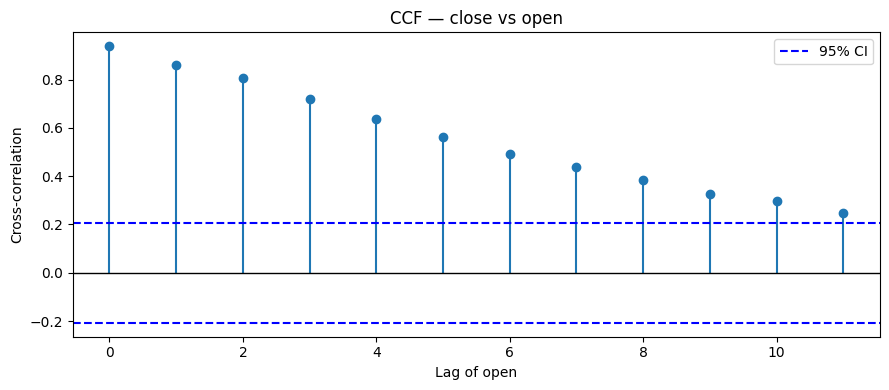

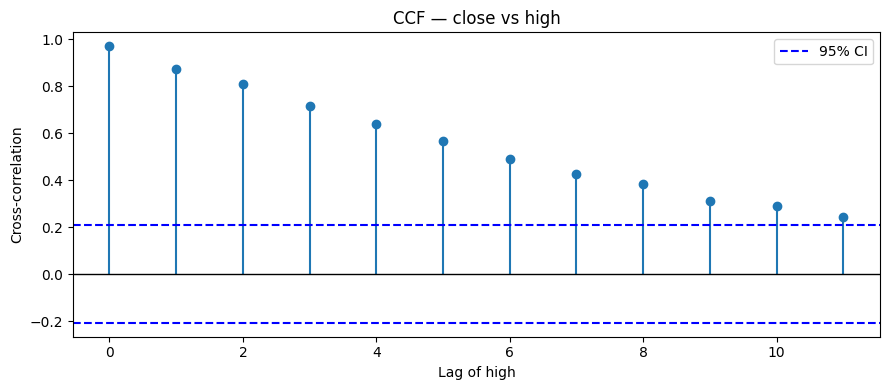

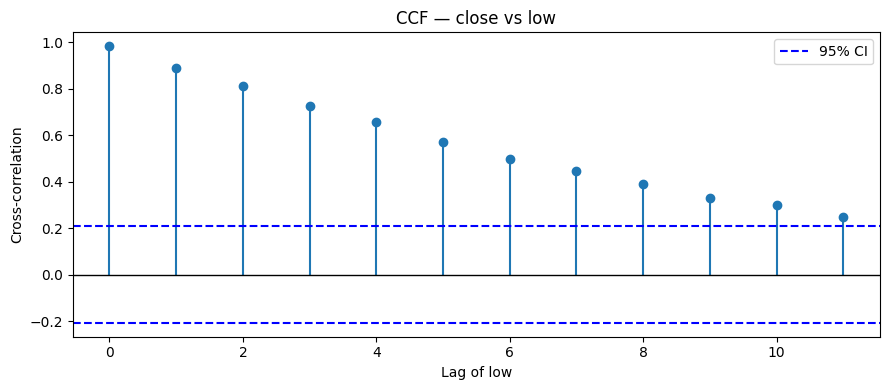

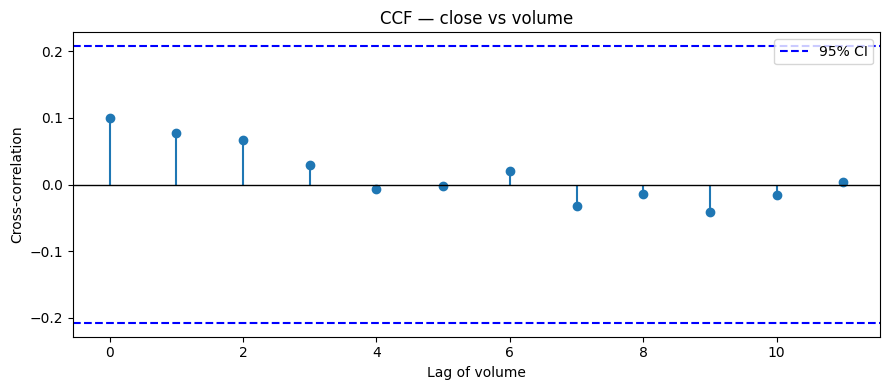

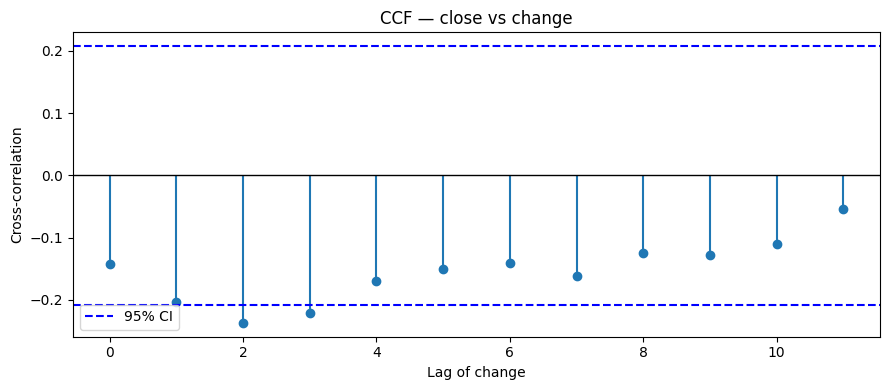

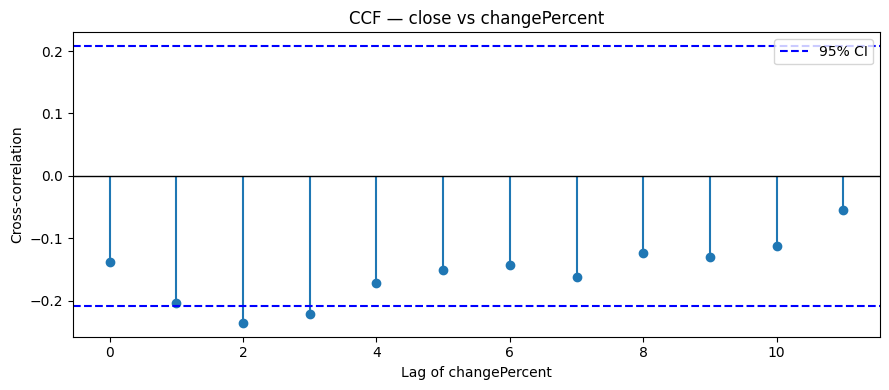

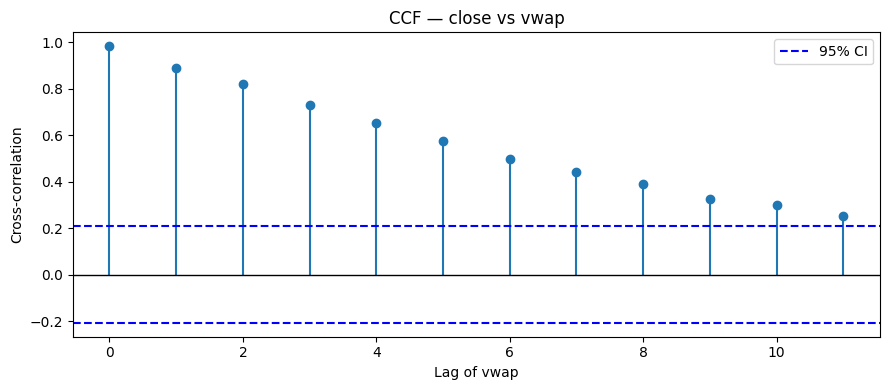

In [37]:

# 1) Validaciones básicas
if "df" not in globals() or "close" not in df.columns:
    raise RuntimeError("El DataFrame 'df' debe estar cargado y contener la columna 'close'.")

# 2) Asegurar orden temporal y eliminar nulos
df_ccf = df.sort_values("date").dropna(subset=["close"]).reset_index(drop=True)

# 3) Seleccionar columnas numéricas distintas a 'close'
num_cols = df_ccf.select_dtypes(include=[np.number]).columns.drop("close", errors="ignore")

# 4) Parámetros generales
max_lags = 12  # número máximo de rezagos a mostrar

# 5) Iterar por cada variable numérica y graficar su CCF con 'close'
for col in num_cols:
    # Calcular la CCF
    ccf_vals = ccf(df_ccf["close"], df_ccf[col], adjusted=False)
    n = len(df_ccf)

    # Limitar número de rezagos
    lags = np.arange(max_lags)

    # Crear figura
    plt.figure(figsize=(9, 4))
    plt.stem(lags, ccf_vals[:max_lags], basefmt=" ")
    plt.axhline(0, color="black", linewidth=1)
    plt.axhline(1.96 / np.sqrt(n), color="blue", linestyle="--", label="95% CI")
    plt.axhline(-1.96 / np.sqrt(n), color="blue", linestyle="--")
    plt.title(f"CCF — close vs {col}")
    plt.xlabel(f"Lag of {col}")
    plt.ylabel("Cross-correlation")
    plt.legend()
    plt.tight_layout()
    plt.show()


###  Variables exógenas 


Variable principal: close 
Variable en X: date 

Variables exogenas propuestas hasta este punto: 
- open
- high
- low
- change percentage 

### Train / test

In [38]:

# 1) Asegurar que 'date' sea datetime y ordenarlo
df_sarimax = df.copy()
df_sarimax["date"] = pd.to_datetime(df_sarimax["date"])
df_sarimax = df_sarimax.sort_values("date")

# 2) Establecer 'date' como índice
df_sarimax = df_sarimax.set_index("date")

# 3) División temporal (últimos 5 registros para test)
train = df_sarimax.iloc[:-5]
test  = df_sarimax.iloc[-5:]

# 4) Definir variable dependiente (y) y exógenas (X)
y_train = train["close"]
X_train = train[["open", "high", "low", "changePercent"]]

y_test = test["close"]
X_test = test[["open", "high", "low", "changePercent"]]

# (opcional) Confirmar índices y tamaños
print("Train range:", y_train.index.min(), "→", y_train.index.max(), "| n:", len(train))
print("Test range:",  y_test.index.min(),  "→", y_test.index.max(),  "| n:", len(test))


Train range: 2025-06-12 00:00:00 → 2025-10-10 00:00:00 | n: 84
Test range: 2025-10-13 00:00:00 → 2025-10-17 00:00:00 | n: 5


###  Estacionalidad

In [39]:


# 2) Helpers de prueba (breve)
def adf_test(series, title=""):
    s = series.dropna()
    stat, pval, *_rest = adfuller(s)
    crit = adfuller(s)[4]  # valores críticos
    print(f"[ADF] {title}  ->  stat={stat:.4f}  p={pval:.4g}")
    for k,v in crit.items():
        print(f"   crit[{k}]: {v:.4f}")
    print()

def kpss_test(series, title=""):
    s = series.dropna()
    stat, pval, lags, crit = kpss(s, regression="c", nlags="auto")
    print(f"[KPSS] {title} ->  stat={stat:.4f}  p={pval:.4g}  (lags={lags})")
    for k,v in crit.items():
        print(f"   crit[{k}]: {v:.4f}")
    print()

# 3) Ejecutar pruebas sobre y y X
targets = [("close (y_train)", y_train)]
for col in X_train.columns:
    targets.append((f"{col} (X_train)", X_train[col]))

for name, s in targets:
    try:
        adf_test(s, title=name)
    except Exception as e:
        print(f"[ADF] {name} -> error: {e}\n")
    try:
        kpss_test(s, title=name)
    except Exception as e:
        print(f"[KPSS] {name} -> error: {e}\n")


[ADF] close (y_train)  ->  stat=-2.5914  p=0.09479
   crit[1%]: -3.5127
   crit[5%]: -2.8975
   crit[10%]: -2.5859

[KPSS] close (y_train) ->  stat=0.6303  p=0.01988  (lags=5)
   crit[10%]: 0.3470
   crit[5%]: 0.4630
   crit[2.5%]: 0.5740
   crit[1%]: 0.7390

[ADF] open (X_train)  ->  stat=-2.3160  p=0.1669
   crit[1%]: -3.5127
   crit[5%]: -2.8975
   crit[10%]: -2.5859

[KPSS] open (X_train) ->  stat=0.5807  p=0.02439  (lags=5)
   crit[10%]: 0.3470
   crit[5%]: 0.4630
   crit[2.5%]: 0.5740
   crit[1%]: 0.7390

[ADF] high (X_train)  ->  stat=-2.3045  p=0.1705
   crit[1%]: -3.5127
   crit[5%]: -2.8975
   crit[10%]: -2.5859

[KPSS] high (X_train) ->  stat=0.5876  p=0.02376  (lags=5)
   crit[10%]: 0.3470
   crit[5%]: 0.4630
   crit[2.5%]: 0.5740
   crit[1%]: 0.7390

[ADF] low (X_train)  ->  stat=-2.4802  p=0.1204
   crit[1%]: -3.5117
   crit[5%]: -2.8970
   crit[10%]: -2.5857

[KPSS] low (X_train) ->  stat=0.6016  p=0.02249  (lags=5)
   crit[10%]: 0.3470
   crit[5%]: 0.4630
   crit[2.5%]:

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1318379079.py:13: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [40]:

# 1) Asegurar orden temporal
y_train_diff = y_train.copy()

# 2) Diferenciación de primer orden
y_train_diff = y_train_diff.diff()

# 4) Ejecutar pruebas sobre la serie diferenciada
adf_test(y_train_diff, title= "(1st difference)")
kpss_test(y_train_diff, title= "(1st difference)")


[ADF] (1st difference)  ->  stat=-11.3744  p=8.818e-21
   crit[1%]: -3.5127
   crit[5%]: -2.8975
   crit[10%]: -2.5859

[KPSS] (1st difference) ->  stat=0.1246  p=0.1  (lags=0)
   crit[10%]: 0.3470
   crit[5%]: 0.4630
   crit[2.5%]: 0.5740
   crit[1%]: 0.7390



/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1318379079.py:13: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




###  Selección de órdenes

Con una diferenciacion se determina que se vuelve estacionaria la serie de interes.

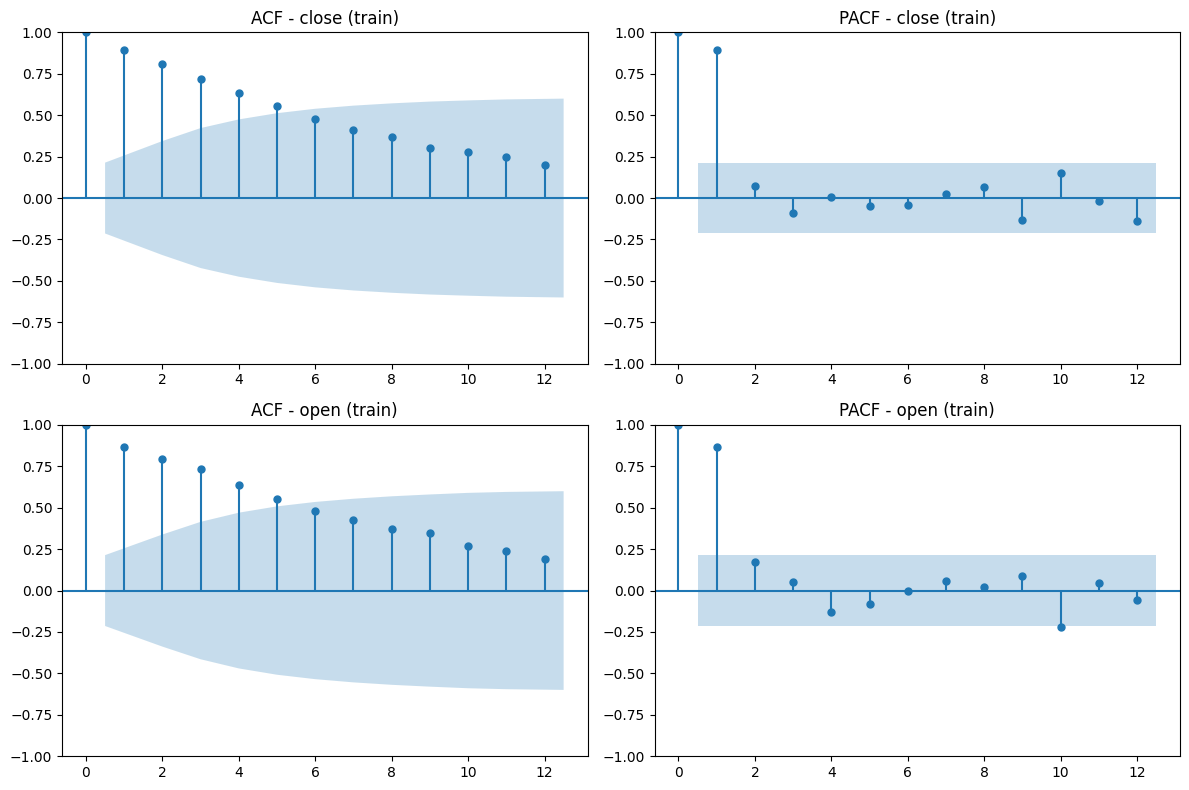

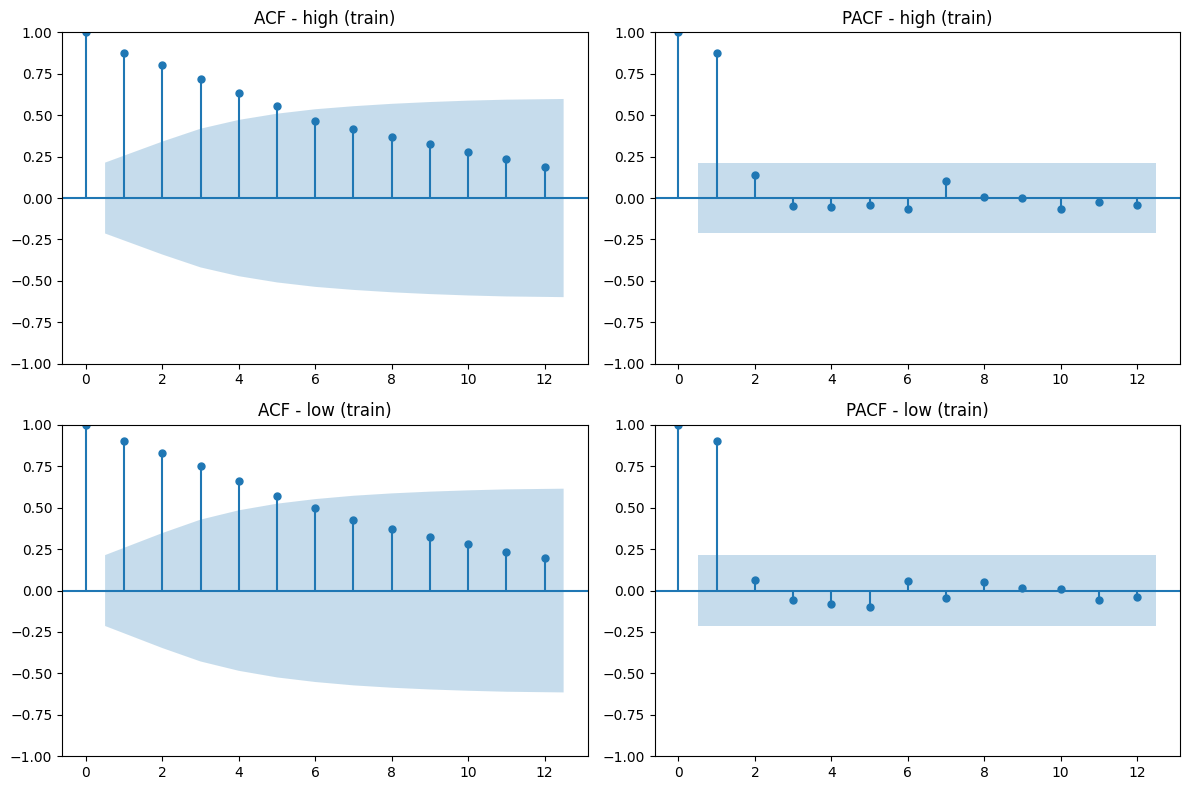

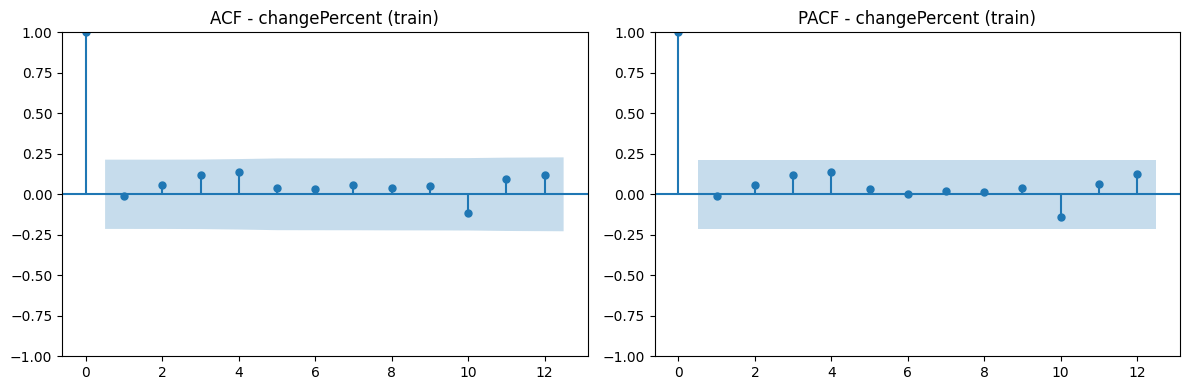

In [41]:
# --- ACF/PACF para endógena (close) y exógenas propuestas ---


fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF close
plot_acf(y_train.dropna(), lags=12, ax=axes[0, 0])
axes[0, 0].set_title("ACF - close (train)")

# PACF close
plot_pacf(y_train.dropna(), lags=12, ax=axes[0, 1], method="ywm")
axes[0, 1].set_title("PACF - close (train)")

# ACF open
plot_acf(X_train["open"].dropna(), lags=12, ax=axes[1, 0])
axes[1, 0].set_title("ACF - open (train)")

# PACF open
plot_pacf(X_train["open"].dropna(), lags=12, ax=axes[1, 1], method="ywm")
axes[1, 1].set_title("PACF - open (train)")

plt.tight_layout()
plt.show()

# --- Segunda figura con las otras exógenas ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ACF high
plot_acf(X_train["high"].dropna(), lags=12, ax=axes[0, 0])
axes[0, 0].set_title("ACF - high (train)")

# PACF high
plot_pacf(X_train["high"].dropna(), lags=12, ax=axes[0, 1], method="ywm")
axes[0, 1].set_title("PACF - high (train)")

# ACF low
plot_acf(X_train["low"].dropna(), lags=12, ax=axes[1, 0])
axes[1, 0].set_title("ACF - low (train)")

# PACF low
plot_pacf(X_train["low"].dropna(), lags=12, ax=axes[1, 1], method="ywm")
axes[1, 1].set_title("PACF - low (train)")

plt.tight_layout()
plt.show()

# --- Tercera figura con changePercent ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(X_train["changePercent"].dropna(), lags=12, ax=axes[0])
axes[0].set_title("ACF - changePercent (train)")

plot_pacf(X_train["changePercent"].dropna(), lags=12, ax=axes[1], method="ywm")
axes[1].set_title("PACF - changePercent (train)")

plt.tight_layout()
plt.show()


In [42]:


trends = ['n','c','ct','t']
seasonals = [
    (0,1,1,2), (1,1,0,2), (0,0,0,2),
    (0,0,0,1), (0,1,1,1), (1,1,0,1),
    (0,1,1,0), (1,1,0,0), (0,0,0,0),
    (0,1,1,5), (1,1,0,5), (0,0,0,5)
]
X_cols = list(X_train.columns)

for tr in trends:
    for seas in seasonals:
        try:
            model = SARIMAX(
                y_train, exog=X_train[X_cols],
                order=(1,1,1), seasonal_order=seas, trend=tr,
                enforce_stationarity=False, enforce_invertibility=False
            )
            fit = model.fit(disp=False, maxiter=1000)
            print(fit.summary(), f"trend={tr}, seasonal_order={seas}")
            fc = fit.get_forecast(steps=len(X_test), exog=X_test[X_cols])
            # Predicciones
            mean_test = fc.predicted_mean
            conf_int  = fc.conf_int()

            # Accuracy metrics
            mae = mean_absolute_error(y_test, mean_test)
            mse = mean_squared_error(y_test, mean_test)
            mape = (abs((y_test - mean_test) / y_test).mean()) * 100

            print(f"Test MAE: {mae:.4f} | MSE: {mse:.4f} | MAPE: {mape:.2f}%")

            pred_idx = X_test.index
            mean_test.index = pred_idx
            conf_int.index  = pred_idx

        except Exception as e:
            print(f"[SKIPPED] trend={tr}, seasonal_order={seas} -> {e}")
            continue


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not 

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 2)   Log Likelihood                  30.193
Date:                           Fri, 17 Oct 2025   AIC                            -44.385
Time:                                   21:27:23   BIC                            -25.635
Sample:                                        0   HQIC                           -36.885
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.9473      0.027     34.474      0.000       0.893       1.001
high             -0.0083      0.01

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                  25.557
Date:                           Fri, 17 Oct 2025   AIC                            -35.114
Time:                                   21:27:24   BIC                            -17.013
Sample:                                        0   HQIC                           -27.916
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
open              0.9492      0.031     30.320      0.000       0.888       1.011
high             -0.0048      0.01

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 2)   Log Likelihood                  30.204
Date:                           Fri, 17 Oct 2025   AIC                            -42.408
Time:                                   21:27:24   BIC                            -21.314
Sample:                                        0   HQIC                           -33.971
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.0002      0.000     -0.745      0.456      -0.001       0.000
open              0.9278      0.02

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   84
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  36.771
Date:                Fri, 17 Oct 2025   AIC                            -57.541
Time:                        21:27:24   BIC                            -38.386
Sample:                             0   HQIC                           -49.856
                                 - 84                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0036      0.001      2.753      0.006       0.001       0.006
open              0.9457      0.027     34.989      0.000       0.893       0.999
high             -0.0080      0.014     

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                  26.428
Date:                           Fri, 17 Oct 2025   AIC                            -34.856
Time:                                   21:27:24   BIC                            -14.492
Sample:                                        0   HQIC                           -26.758
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.0005      0.001     -0.660      0.509      -0.002       0.001
open              0.9468      0.03

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   84
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  36.771
Date:                Fri, 17 Oct 2025   AIC                            -57.541
Time:                        21:27:25   BIC                            -38.386
Sample:                             0   HQIC                           -49.856
                                 - 84                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0036      0.001      2.753      0.006       0.001       0.006
open              0.9457      0.027     34.989      0.000       0.893       0.999
high             -0.0080      0.014     

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   84
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  34.885
Date:                Fri, 17 Oct 2025   AIC                            -51.770
Time:                        21:27:25   BIC                            -30.220
Sample:                             0   HQIC                           -43.124
                                 - 84                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0116      0.006      1.875      0.061      -0.001       0.024
drift            -0.0002      0.000     -1.452      0.146      -0.000    6.26e-05
open              0.9777      0.034     

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                  17.940
Date:                           Fri, 17 Oct 2025   AIC                            -15.880
Time:                                   21:27:25   BIC                              6.747
Sample:                                        0   HQIC                            -6.882
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.0094      0.011     -0.868      0.385      -0.031       0.012
drift             0.0002      0.00

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   84
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  34.885
Date:                Fri, 17 Oct 2025   AIC                            -51.770
Time:                        21:27:26   BIC                            -30.220
Sample:                             0   HQIC                           -43.124
                                 - 84                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept         0.0116      0.006      1.875      0.061      -0.001       0.024
drift            -0.0002      0.000     -1.452      0.146      -0.000    6.26e-05
open              0.9777      0.034     

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

                                     SARIMAX Results                                      
Dep. Variable:                              close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 5)   Log Likelihood                  13.397
Date:                            Fri, 17 Oct 2025   AIC                             -8.793
Time:                                    21:27:26   BIC                             11.697
Sample:                                         0   HQIC                            -0.636
                                             - 84                                         
Covariance Type:                              opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
drift          9.342e-06      0.000      0.044      0.965      -0.000       0.000
open              0.9726  

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/1696957620.py:28: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

###  Criterios (AIC/BIC)

| #  | Trend | Seasonal (P,D,Q,s) | AIC        | BIC    | MAE        | MSE        |
| -- | :---- | :----------------- | :--------- | :----- | :--------- | :--------- |
| 1  | c     | (0,0,0,2)          | **-57.54** | -38.39 | 0.0653     | 0.0054     |
| 2  | n     | (1,1,1,0)          | -51.73     | -34.97 | 0.0354     | 0.0021     |
| 3  | ct    | (1,1,1,0)          | -51.77     | -30.22 | 0.0383     | 0.0019     |
| 4  | n     | (1,1,1,0)          | -51.73     | -34.97 | 0.0354     | 0.0021     |
| 5  | t     | (1,1,1,0)          | -48.54     | -29.38 | 0.0751     | 0.0072     |
| 6  | n     | (0,1,1,2)          | -44.38     | -25.64 | 0.0679     | 0.0061     |
| 7  | c     | (0,1,1,2)          | -42.41     | -21.31 | 0.0410     | 0.0031     |
| 8  | n     | (0,1,1,5)          | -35.11     | -17.01 | 0.0586     | 0.0037     |
| 9  | c     | (0,1,1,5)          | -34.86     | -14.49 | **0.0177** | **0.0005** |
| 10 | n     | (1,1,0,2)          | -23.44     | -4.59  | 0.1270     | 0.0224     |
| 11 | c     | (1,1,0,2)          | -22.70     | -1.49  | 0.0921     | 0.0116     |
| 12 | t     | (1,1,0,2)          | -18.57     | 2.64   | 0.0867     | 0.0094     |
| 13 | n     | (0,1,1,5)          | -16.43     | 3.94   | 0.1822     | 0.0338     |
| 14 | t     | (0,1,1,5)          | -15.88     | 6.75   | 0.2555     | 0.0671     |
| 15 | c     | (1,1,0,5)          | -15.59     | 2.63   | 0.1032     | 0.0146     |
| 16 | t     | (1,1,0,5)          | -8.79      | 11.70  | 0.2625     | 0.0701     |
| 17 | ct    | (1,1,0,5)          | -8.55      | 14.22  | 0.3265     | 0.1083     |
| 18 | t     | (0,1,1,2)          | -13.84     | 7.25   | 0.1099     | 0.0147     |
| 19 | ct    | (0,1,1,2)          | -12.07     | 11.37  | 0.1318     | 0.0209     |
| 20 | n     | (1,1,0,5)          | -15.59     | 2.63   | 0.1032     | 0.0146     |


### Mejor modelo

Nos quedamos con el modelo 

| #  | Trend | Seasonal (P,D,Q,s) | AIC        | BIC    | MAE        | MSE        |
| -- | :---- | :----------------- | :--------- | :----- | :--------- | :--------- |
| 9  | c     | (0,1,1,5)          | -34.86     | -14.49 | **0.0177** | **0.0005** |


porque, aunque no tiene el mejor AIC ni BIC, resulta mas logico su s = 5 por la naturalidad de los datos, ademas es el mejor en MAE y MSE, igual que en la d, la D es = a 1 por la diferenciacion que necesito para la estacionalidad, el tren c fue el que explico el mejor modelo segun AIC y BIC y tambien MAE y MSE entonces nos quedamos con c, por ultimo p = 1 por el PACF de close especificamente, y por las mismas graficas de sus exogenas P = 0 ya que no todas llegan al 1 en esa grafica, q = 1 por la parte de ACF de close donde se ve que la variable anterior es siempre importante para el nuevo valor, finalmente Q = 1 por las mismas graficas de sus exogenas. 

In [43]:

X_cols = list(X_train.columns)


model = SARIMAX(
    y_train, exog=X_train[X_cols],
    order=(1,1,1), seasonal_order=(0,1,1,5), trend='c',
    enforce_stationarity=False, enforce_invertibility=False
)
fit = model.fit(disp=False, maxiter=1000)
print(fit.summary(), f"trend='c', seasonal_order=(0,1,1,5)")
fc = fit.get_forecast(steps=len(X_test), exog=X_test[X_cols])
# Predicciones
mean_test = fc.predicted_mean
conf_int  = fc.conf_int()

# Accuracy metrics
mae = mean_absolute_error(y_test, mean_test)
mse = mean_squared_error(y_test, mean_test)
mape = (abs((y_test - mean_test) / y_test).mean()) * 100

print(f"Test MAE: {mae:.4f} | MSE: {mse:.4f} | MAPE: {mape:.2f}%")

pred_idx = X_test.index
mean_test.index = pred_idx
conf_int.index  = pred_idx

fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode="lines+markers", name="Train"))
fig.add_trace(go.Scatter(x=y_test.index,  y=y_test,  mode="lines+markers", name="Real Test", line=dict(color="green")))
fig.add_trace(go.Scatter(x=mean_test.index, y=mean_test, mode="lines+markers",
                         name="Forecast (Test)", line=dict(color="orange")))
fig.add_trace(go.Scatter(x=conf_int.index, y=conf_int.iloc[:, 0],
                         line=dict(color="lightgrey"), showlegend=False))
fig.add_trace(go.Scatter(x=conf_int.index, y=conf_int.iloc[:, 1],
                         fill="tonexty", line=dict(color="lightgrey"),
                         name="95% Confidence Interval"))
fig.update_layout(
    title=f"SARIMAX Forecast vs Test Data — trend='c' | seasonal_order=(0,1,1,5)",
    xaxis_title="Time", yaxis_title=str(y_train.name)
)
fig.show()

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                  26.428
Date:                           Fri, 17 Oct 2025   AIC                            -34.856
Time:                                   21:27:26   BIC                            -14.492
Sample:                                        0   HQIC                           -26.758
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.0005      0.001     -0.660      0.509      -0.002       0.001
open              0.9468      0.03

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/3721912255.py:19: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.



### Predicciones

In [44]:
# ---------------------------
# 1) Ajuste (tú ya lo tienes)
# ---------------------------
X_cols = list(X_train.columns)
model = SARIMAX(
    y_train, exog=X_train[X_cols],
    order=(1,1,1), seasonal_order=(0,1,1,5), trend='c',
    enforce_stationarity=False, enforce_invertibility=False
)
fit = model.fit(disp=False, maxiter=1000)
print(fit.summary(), "trend='c', seasonal_order=(0,1,1,5)")

# ---------------------------------
# 2) Pronóstico sobre el set de test
# ---------------------------------
fc_test = fit.get_forecast(steps=len(X_test), exog=X_test[X_cols])
mean_test = fc_test.predicted_mean
conf_test = fc_test.conf_int()

# Métricas test (opcional)
mae = mean_absolute_error(y_test, mean_test)
mse = mean_squared_error(y_test, mean_test)
mape = (abs((y_test - mean_test) / y_test).replace([np.inf, -np.inf], np.nan).dropna().mean()) * 100
print(f"Test MAE: {mae:.4f} | MSE: {mse:.4f} | MAPE: {mape:.2f}%")

# Alinear índices al índice del test
mean_test.index = X_test.index
conf_test.index  = X_test.index

# ------------------------------------------------------
# 3) Construir índice de las 5 fechas hábiles
#    posteriores al último punto del test (sin fines de semana)
# ------------------------------------------------------
def _next_5_index(idx: pd.DatetimeIndex) -> pd.DatetimeIndex:
    # Asegura tipo DatetimeIndex
    if not isinstance(idx, pd.DatetimeIndex):
        idx = pd.to_datetime(idx)

    # Comienza el siguiente día hábil y toma 5 períodos "B" (business days)
    start = idx[-1] + pd.tseries.offsets.BDay(1)
    return pd.bdate_range(start=start, periods=5, freq="B")

future_index = _next_5_index(X_test.index)


# ------------------------------------------------------
# 4) Preparar exógenas futuras (X_future) para 5 pasos
#    *** REEMPLAZA este placeholder por tus verdaderas
#    exógenas futuras cuando las tengas ***
# ------------------------------------------------------
# Ejemplo simple: repetir la última fila conocida de X_test
X_future = pd.DataFrame(
    np.repeat(X_test[X_cols].iloc[[-1]].values, repeats=5, axis=0),
    index=future_index, columns=X_cols
)

# ------------------------------------------------------
# 4.5) *** NUEVO *** Reentrenar con TRAIN + TEST antes del forecast futuro
# ------------------------------------------------------
y_full = pd.concat([y_train, y_test]).astype(float)
X_full = pd.concat([X_train[X_cols], X_test[X_cols]]).astype(float)

model_full = SARIMAX(
    y_full, exog=X_full[X_cols],
    order=(1,1,1), seasonal_order=(0,1,1,5), trend='c',
    enforce_stationarity=False, enforce_invertibility=False
)
fit_full = model_full.fit(disp=False, maxiter=1000)

# ------------------------------------------------------
# 5) Pronóstico 5 pasos fuera de muestra (usando el modelo reentrenado)
# ------------------------------------------------------
fc_future = fit_full.get_forecast(steps=5, exog=X_future[X_cols])
mean_future = fc_future.predicted_mean
conf_future = fc_future.conf_int()
mean_future.index = future_index
conf_future.index  = future_index

# ------------------------------------------------------
# 6) Tabla solicitada (solo los 5 días futuros)
# ------------------------------------------------------
tabla_5 = pd.DataFrame({
    "date": mean_future.index.strftime("%Y-%m-%d"),
    "pred_close_sarimax": mean_future.values
})
# Mírala en texto:
print(tabla_5.to_string(index=False))

# Si quieres exactamente en Markdown:
print("\n| date | pred_close_sarimax |\n|---|---|")
for d, v in zip(tabla_5["date"], tabla_5["pred_close_sarimax"]):
    print(f"| {d} | {v:.6f} |")

# ------------------------------------------------------
# 7) Gráfica: Train, Real Test, Forecast Test, 5 Futuros
# ------------------------------------------------------
fig = go.Figure()

# Train
fig.add_trace(go.Scatter(x=y_train.index, y=y_train, mode="lines+markers", name="Train"))

# Real test
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode="lines+markers",
                         name="Real Test", line=dict(color="green")))

# Forecast sobre test (con IC)
fig.add_trace(go.Scatter(x=mean_test.index, y=mean_test, mode="lines+markers",
                         name="Forecast (Test)", line=dict(color="orange")))
fig.add_trace(go.Scatter(x=conf_test.index, y=conf_test.iloc[:, 0],
                         line=dict(color="lightgrey"), showlegend=False))
fig.add_trace(go.Scatter(x=conf_test.index, y=conf_test.iloc[:, 1],
                         fill="tonexty", line=dict(color="lightgrey"),
                         name="95% CI (Test)"))

# Forecast 5 futuros (con IC) — modelo reentrenado
fig.add_trace(go.Scatter(x=mean_future.index, y=mean_future, mode="lines+markers",
                         name="Forecast (+5 días)", line=dict(dash="dash")))
fig.add_trace(go.Scatter(x=conf_future.index, y=conf_future.iloc[:, 0],
                         line=dict(width=0), showlegend=False))
fig.add_trace(go.Scatter(x=conf_future.index, y=conf_future.iloc[:, 1],
                         fill="tonexty", line=dict(width=0),
                         name="95% CI (+5 días)"))

fig.update_layout(
    title="SARIMAX — Train vs Test vs Forecast (+5 días) | trend='c' | seasonal_order=(0,1,1,5)",
    xaxis_title="date",
    yaxis_title=str(y_train.name),
    legend_title="Series"
)
fig.show()


/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                     SARIMAX Results                                     
Dep. Variable:                             close   No. Observations:                   84
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 5)   Log Likelihood                  26.428
Date:                           Fri, 17 Oct 2025   AIC                            -34.856
Time:                                   21:27:27   BIC                            -14.492
Sample:                                        0   HQIC                           -26.758
                                            - 84                                         
Covariance Type:                             opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -0.0005      0.001     -0.660      0.509      -0.002       0.001
open              0.9468      0.03

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/var/folders/fd/q5kbvbvd00b4rdf_lfzx0j3m0000gp/T/ipykernel_3348/3623660663.py:23: RuntimeWarning:

'<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been

### Predicciones tabla

| date | pred_close_sarimax | pred_close_FNN
|---|---|---|
| 2025-10-20 | 513.641784 | 512.347839
| 2025-10-21 | 513.710796 | 511.750122
| 2025-10-22 | 513.666771 | 511.873840
| 2025-10-23 | 513.656211 | 511.680969
| 2025-10-24 | 513.609880 | 511.871185
